# SnAr Benchmark Visualization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pareto_front import NSGAII
from summit.benchmarks import SnarBenchmark
from summit.utils.dataset import DataSet
from summit.utils.multiobjective import HvI
from summit.strategies import Random

import matplotlib.pyplot as plt
import numpy as np
import json

## Pareto Front

### Random
Here, I am trying to used random search to determine the pareto front. I really do not think that works well though.

In [3]:
def determine_pareto_front(n_points=5000, random_seed=100):
    exp = SnarBenchmark()
    rand = Random(exp.domain, 
                  random_state=np.random.RandomState(random_seed))
    experiments = rand.suggest_experiments(n_points)
    exp.run_experiments(experiments)
    return exp

In [ ]:
exp = determine_pareto_front(n_points=int(2e4))

In [ ]:
fig, ax = exp.pareto_plot()

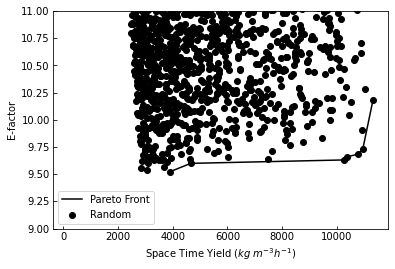

In [17]:
fig, ax = exp.pareto_plot()
names = [r'Space Time Yield ($kg \; m^{-3} h^{-1}$)', 'E-factor']
ax.set_xlabel(names[0])
ax.set_ylabel(names[1])
ax.set_ylim(9, 11)
ax.tick_params(direction='in')

### NSGAII

Here, I am using NSGA to determine the pareto front.

In [50]:
exp = SnarBenchmark()
exp.reset()
optimizer = NSGAII(exp)
r = optimizer.optimize(iterations=int(1e4))

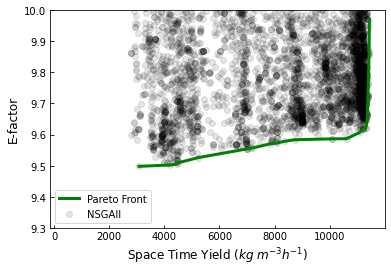

In [64]:
fig, ax = exp.pareto_plot()
names = [r'Space Time Yield ($kg \; m^{-3} h^{-1}$)', 'E-factor']
ax.set_xlabel(names[0], fontsize=12)
ax.set_ylabel(names[1], fontsize=12)
_ = ax.set_ylim(9.3, 10.0)

In [65]:
fig.savefig('pareto_front_snar', dpi=300)

In [53]:
print("Size of the pareto front:", len(exp.pareto_data))

Size of the pareto front: 23


5.776913034365051

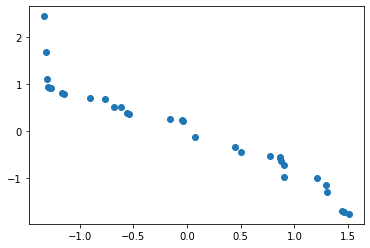

In [142]:
data = exp.pareto_data[['sty', 'e_factor']].to_numpy()
data[:, 0] = -1.0*data[:, 0]
means = np.mean(data, axis=0)
stds = np.std(data, axis=0)
data_std = (data-means)/stds

plt.scatter(data_std[:,0], data_std[:,1])
HvI.hypervolume(data_std, ref=[1.5,2])

In [143]:
exp.data.to_csv('pareto_front_snar.csv')

## Visualize Sensitivity

In [9]:
from pandas.plotting import parallel_coordinates
import pandas as pd
from hiplot import Experiment
import numpy as np
from math import log

In [6]:
ds = DataSet.read_csv('pareto_front_snar.csv')
data_std_arr = ds.standardize()
data = pd.DataFrame(data_std_arr, columns=ds.data_columns)
# parallel_coordinates(data.iloc[9000:int(1e4)], 'strategy', color=("#dcdfe6"), alpha=0.05)

In [7]:
data_log = ds[ds.data_columns].copy()
data_log[('sty', 'DATA')]= data_log['sty'].apply(log)
data_log[('e_factor', 'DATA')]= data_log['e_factor'].apply(log)
data_std_arr = data_log.standardize()
data_log = pd.DataFrame(data_std_arr, columns=ds.data_columns)

In [28]:
Experiment.from_iterable(data_log.to_dict(orient='records')).display()

<IPython.core.display.Javascript object>

In [ ]:
data_log_new = data_log.copy()
data_log_new['strategy'] = 'NSGAII'
parallel_coordinates(data_log_new[data_log['e_factor']<-0.5], 
                     "strategy", 
                     color=("#dcdfe6"), 
                     alpha=0.05,
                     xticks=[r'$\tau$', 'Equiv 1', 'Conc 2', 'Temperature', 'STY'])

## Multiobjective Transforms

### Chimera

Chimera is a scalarisation technique created by Hase et al. 

In [3]:
import mpl_toolkits.mplot3d.art3d as art3d
from mpl_toolkits.mplot3d import Axes3D
from summit.strategies import Chimera

In [165]:
def plot_chimera(hierarchy, ax):
    # Setup 
    exp = SnarBenchmark()
    chim = Chimera(exp.domain, hierarchy)
    r = Random(exp.domain,
               random_state=np.random.RandomState(100))

    # Get data and run chimera transformation
    experiments = r.suggest_experiments(50)
    results =exp.run_experiments(experiments)
    inputs, outputs = chim.transform_inputs_outputs(results)

    # Plot
    x, y, z = results['sty'], results['e_factor'], outputs['chimera']
    ax.scatter(x, y, z, 
               s=100, marker='o')
    for xi, yi, zi in zip(x, y, z):        
        line=art3d.Line3D(*zip((xi, yi, 0), (xi, yi, zi)), markevery=(1, 1))
        ax.add_line(line)
    ax.set_xlabel('sty')
    ax.set_ylabel('E-factor')
    ax.set_zlabel('Chimera')
    ax.view_init(0, 60)
    return ax

In [5]:
# Compare different tolerances
hierarchies = [{'sty': {'hierarchy': 0, 'tolerance': 1}, 
                'e_factor': {'hierarchy': 1, 'tolerance': 1}},
               
               {'sty': {'hierarchy': 0, 'tolerance': 0.5}, 
                'e_factor': {'hierarchy': 1, 'tolerance': 0.5}},
               
               {'sty': {'hierarchy': 0, 'tolerance': 1.0}, 
                'e_factor': {'hierarchy': 1, 'tolerance': 0.5}},
               
               {'sty': {'hierarchy': 0, 'tolerance': 0.5}, 
                'e_factor': {'hierarchy': 1, 'tolerance': 1.0}}
              ]

fig = plt.figure(figsize=(10,10))
for i, hierarchy in enumerate(hierarchies):
    # First plot
    ax = fig.add_subplot(2,2, i+1, projection='3d')
    ax.set_zlim(0,1)
    plot_chimera(hierarchy, ax)
    ax.set_title(f"STY_tol={hierarchy['sty']['tolerance']}, E-factor_tol={hierarchy['e_factor']['tolerance']}")
    fig.tight_layout()
    fig.savefig('chimera_comparison.png', dpi=300)

Note that chimera turns everyhting into a minimization problem. Tolerance is probably not the best descriptor of how this works; a better term would be weighting. Higher tolerance values mean you weight an objective more. The relative weighting is what matters. (1,1) and (0.5,0.5) are identical. However, decreasing the weighting of E-factor with minimal change in STY results in STY being weighted much more heavily.

### Hypervolume Improvement

In [70]:
from summit.strategies import TSEMO2
from summit.utils.multiobjective import HvI, pareto_efficient

In [106]:
def plot_hvi(ax):
    # Setup 
    exp = SnarBenchmark()
    tsemo = TSEMO2(exp.domain)
    r = Random(exp.domain,
               random_state=np.random.RandomState(100))
    
    # Get data and run chimera transformation
    experiments = r.suggest_experiments(50)
    results = exp.run_experiments(experiments)
    inputs, outputs = tsemo.transform.transform_inputs_outputs(results)
    
    # Extra points for evaluation
    new_experiments = r.suggest_experiments(50)
    samples = exp.run_experiments(new_experiments)
    
    #Make STY negative for minimization
    y = outputs.to_numpy()
    y[:, 0] = -1.0*y[:,0]
    samples_inputs, samples_outputs = tsemo.transform.transform_inputs_outputs(samples)
    y_samples = samples_outputs.to_numpy()
    y_samples[:,0] = -1.0*y_samples[:,0]
    
    # Initial pareto front
    y_front, _ = pareto_efficient(y, maximize=False)           
    
    #Reference point
    r = np.max(y_front, axis=0)+0.01*(np.max(y_front, axis=0)-np.min(y_front,axis=0))
    
    # Base hypervolume
    hv_base = HvI.hypervolume(y_front, r)
    
    # Hypervolume Improvement
    hypervolumes = []
    hvi = []
    for sample in y_samples:
        sample = np.atleast_2d(sample)
        y_new = np.append(y_front,sample, axis=0)
        y_front_new, _ = pareto_efficient(y_new, maximize=False)
        hv = HvI.hypervolume(y_front_new, r)
        hypervolumes.append(hv)
        hvi.append(hv-hv_base)

    # Plot
    x, y, z = y_samples[:,0], y_samples[:,1], hvi
    ax.scatter(x, y, z, 
               s=100, marker='o')
    for xi, yi, zi in zip(x, y, z):        
        line=art3d.Line3D(*zip((xi, yi, 0), (xi, yi, zi)), markevery=(1, 1))
        ax.add_line(line)
    ax.set_xlabel('sty')
    ax.set_ylabel('E-factor')
    ax.set_zlabel('Hypervolume Improvement')
    ax.view_init(0, 60)
    return ax, hypervolumes, hvi

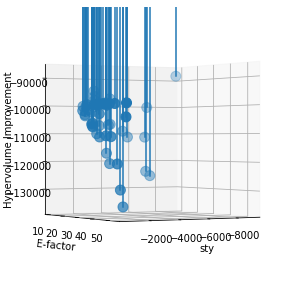

In [107]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax, hv, hvi = plot_hvi(ax)
fig.savefig('hypervolume')

## Experiments

In [87]:
from snar_experiment_visualization import PlotExperiments
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())  #load neptune api token
import pandas as pd

In [162]:
pe = PlotExperiments('sustainable-processes/summit',
                    experiment_ids=[f'SUM-{id}' for id in range(605, 695)])

In [163]:
pe.iterations_to_threshold()

name  mean_iterations  \
0      SOBO, MultitoSingleObjective, batch size=5       115.411765   
1  SNOBFIT, MultitoSingleObjective, batch size=10        24.000000   
2   Random, MultitoSingleObjective, batch size=10       517.333333   
3     SOBO, MultitoSingleObjective, batch size=10        87.230769   

   std_iterations  
0       96.940284  
1       11.163557  
2      135.590888  
3       70.140687

In [ ]:
from summit.